In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/content


Streaming output truncated to the last 5000 lines.


<Axes: >

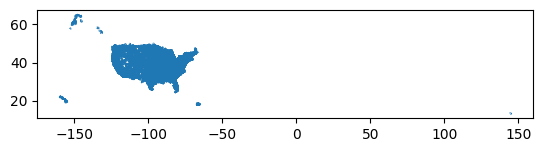

In [ ]:
# University of Washington
# NASA-JPL
# 2024 UW-ENGINE Capstone Project
# Title: Data Science for Discovery

import folium
import pandas as pd
import geopandas as gpd
import os

# Get the current working directory
current_directory = os.getcwd()
print(current_directory)
# Load & Read GeoJSON file
file_path = "/drive/MyDrive/2024 UW ENGINE Capstone/data/maps/U.S._Electric_Power_Transmission_Lines.geojson"
gdf = gpd.read_file(current_directory + file_path)

# Convert timeframes to folium-friendly types
gdf['SOURCEDATE'] = pd.to_datetime(gdf['SOURCEDATE']).dt.strftime('%Y-%m-%dT%H:%M:%S')
gdf['VAL_DATE'] = pd.to_datetime(gdf['VAL_DATE']).dt.strftime('%Y-%m-%dT%H:%M:%S')


Text(0.5, 1.0, 'Major US Transmission Lines')

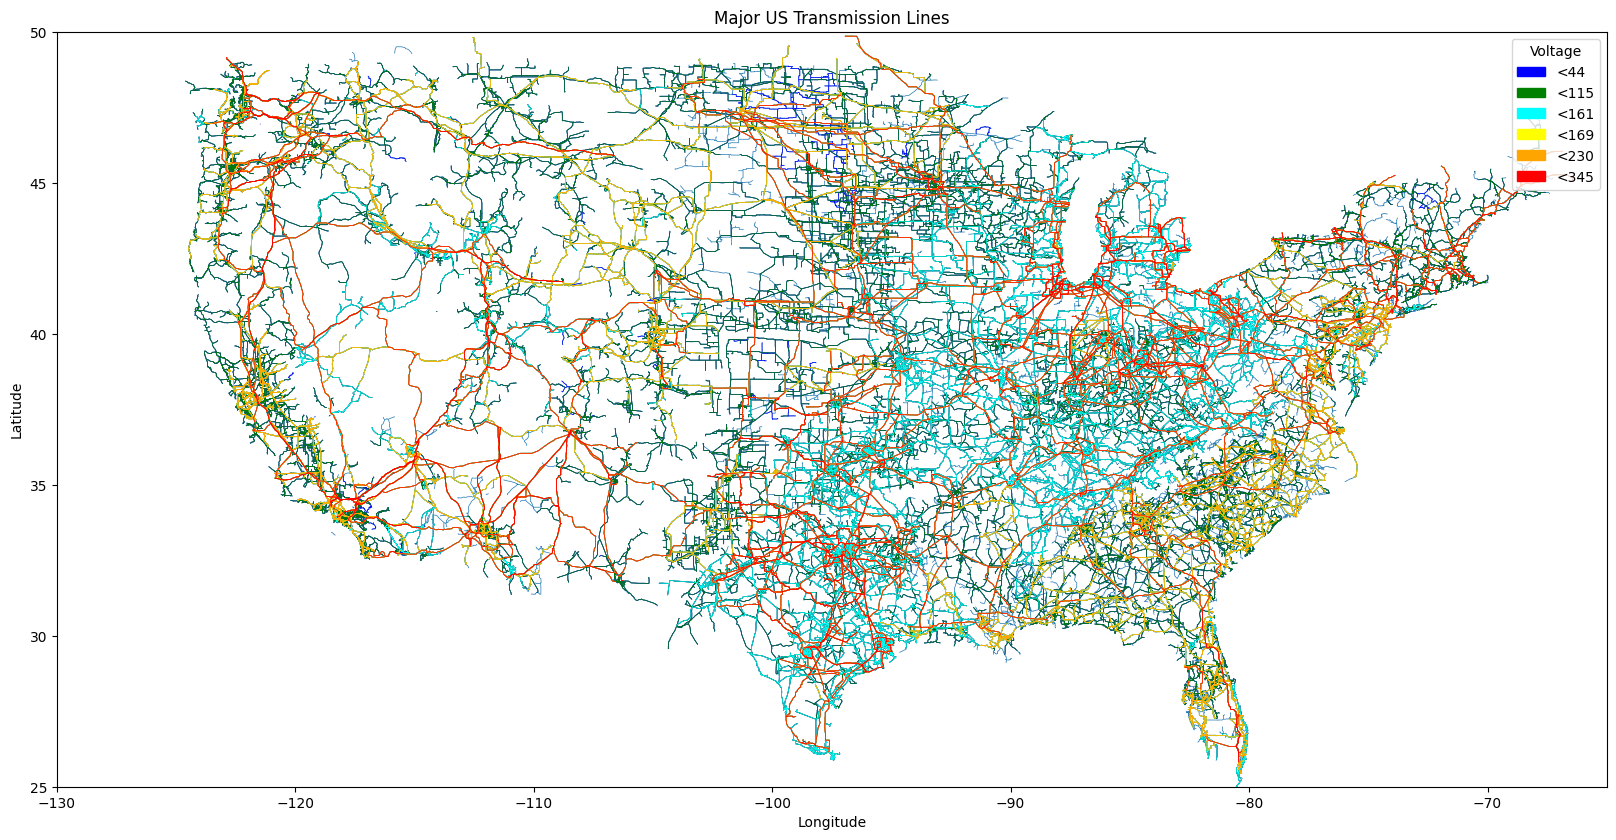

In [ ]:
from matplotlib.patches import Patch
# Plot the GeoDataFrame
map = gdf.plot(figsize=(20, 16),linewidth=0.5)

# Define common voltages and corresponding colors
common_voltages = [0, 44, 115, 161, 169, 230, 345]
hex_colors = ['blue','green', 'cyan', 'yellow', 'orange', 'red']
legend_labels = ['<' + str(i) for i in common_voltages[1:]]

# Plot overlays for each common voltage
for voltage, color, label in zip(common_voltages, hex_colors, legend_labels):
    overlay = gdf[gdf['VOLTAGE'] > voltage]  # Filter GeoDataFrame based on voltage
    overlay.plot(ax=map, marker='o', color=color, markersize=5, linewidth=0.5, label=label)

# Create a custom legend with colored patches
legend_handles = [Patch(color=color, label=label) for color, label in zip(hex_colors, legend_labels)]

# Add legend
map.legend(handles=legend_handles, title='Voltage', loc='upper right')

# Set xy axis limits
map.set_xlim((-130, -65))
map.set_ylim((25,50))

# Put labels on the map
map.set_xlabel("Longitude")
map.set_ylabel("Latitude")
map.set_title("Major US Transmission Lines")



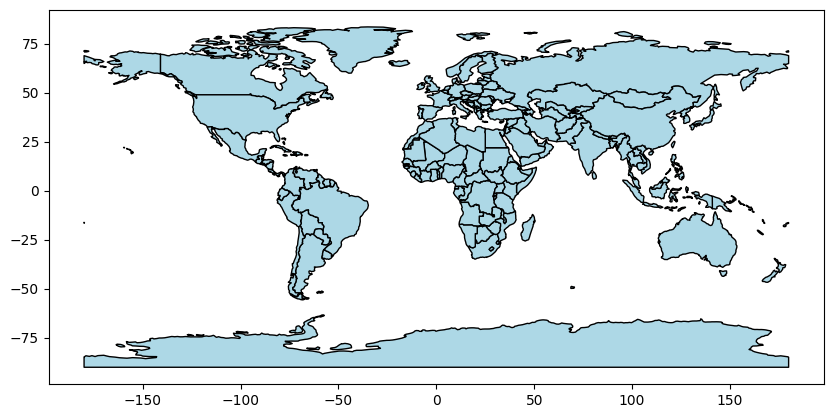

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Plot the GeoDataFrame using Geopandas (Matplotlib plot)
ax = gdf.plot(figsize=(10, 6), color='lightblue', edgecolor='black')

# Convert the Matplotlib plot to a Plotly plot
fig = go.Figure()

# Extract the Matplotlib plot as an image
fig.add_layout_image(
    dict(
        source=plt.savefig("temp.png"),
        x=0,
        sizex=1,
        y=0,
        sizey=1,
        xref="paper",
        yref="paper",
        opacity=1.0,
        layer="below"
    )
)

# Adjust layout if necessary
fig.update_layout(
    title="GeoDataFrame Plot converted to Plotly",
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
)

# Show the Plotly plot
fig.show()


ImportError: cannot import name 'mpl_to_plotly' from 'plotly.utils' (/usr/local/lib/python3.10/dist-packages/plotly/utils.py)

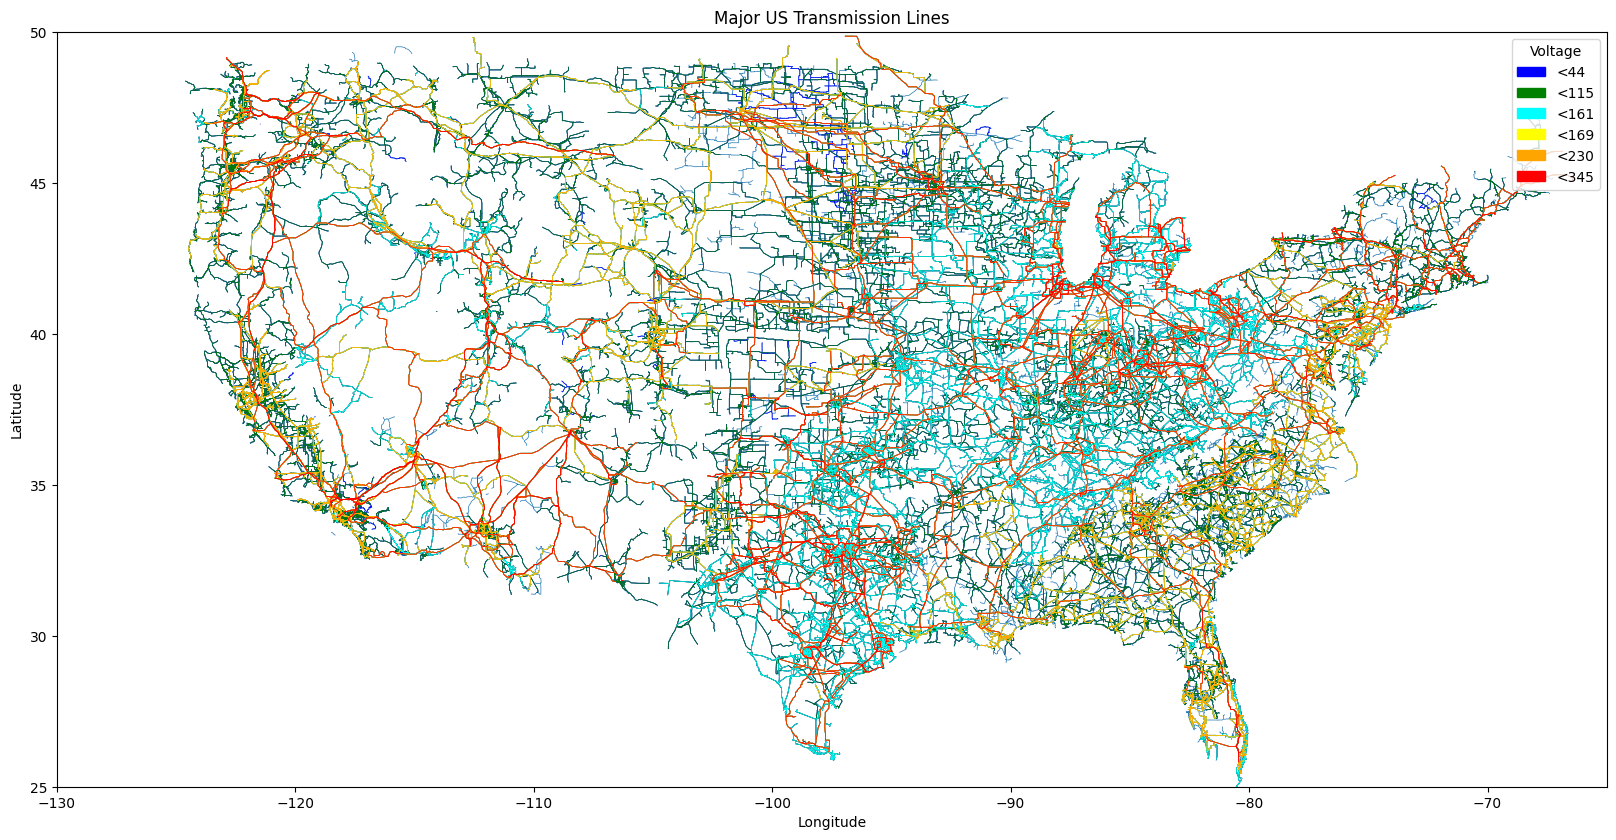

In [ ]:
# Converting to plotly.
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import geopandas as gpd

# Plot the GeoDataFrame using Matplotlib
fig, ax = plt.subplots(figsize=(20, 16))
gdf.plot(ax=ax, linewidth=0.5)
common_voltages = [0, 44, 115, 161, 169, 230, 345]
hex_colors = ['blue','green', 'cyan', 'yellow', 'orange', 'red']
legend_labels = ['<' + str(i) for i in common_voltages[1:]]

# Plot overlays for each common voltage
for voltage, color, label in zip(common_voltages, hex_colors, legend_labels):
    overlay = gdf[gdf['VOLTAGE'] > voltage]
    overlay.plot(ax=ax, marker='o', color=color, markersize=5, linewidth=0.5, label=label)

# Create custom legend with colored patches
legend_handles = [Patch(color=color, label=label) for color, label in zip(hex_colors, legend_labels)]

# Set xy axis limits
ax.set_xlim((-130, -65))
ax.set_ylim((25,50))

# Put labels on the map
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Major US Transmission Lines")

# Add legend
ax.legend(handles=legend_handles, title='Voltage', loc='upper right')

# Convert Matplotlib plot to Plotly
def mpl_to_plotly(fig_mpl):
    import plotly.graph_objs as go
    from plotly.utils import mpl_to_plotly as mpt
    # Convert Matplotlib figure to Plotly figure
    fig_plotly = mpt(fig_mpl)
    # Add x and y axis titles and figure title
    fig_plotly['layout']['xaxis']['title'] = fig_mpl.axes[0].get_xlabel()
    fig_plotly['layout']['yaxis']['title'] = fig_mpl.axes[0].get_ylabel()
    fig_plotly['layout']['title'] = fig_mpl._suptitle.get_text()
    return fig_plotly

# Convert Matplotlib figure to Plotly
plotly_fig = mpl_to_plotly(fig)

# Show Plotly figure
plotly_fig.show()

In [ ]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
import seaborn as sns

# File path, time column name, and GIC column name
file_paths = ['2023E03_10211.csv', '2023E03_10212.csv', '2023E03_10251.csv']
time_column = 'SampleDateTime'
gic_column = 'GICMeasured'
latitudes = [34.3, 36, 35.9]  # Latitude of the corresponding file (monitor)

# A list of stores for resampled data
resampled_data = []

# Extract the time and determine the common time point
for file_path, latitude in zip(file_paths, latitudes):
    df = pd.read_csv(file_path, usecols=[time_column, gic_column])
    df[time_column] = pd.to_datetime(df[time_column])

    # Set the datetime object as an index
    df.set_index(time_column, inplace=True)
    # Stores resampling data for each file
    resampled_data.append(df.resample('T').mean().interpolate())  # 'T' stands for every minute

# Resampling to a common time point
# Find the intersection of all time points
common_times = resampled_data[0].index
for data in resampled_data[1:]:
    common_times = common_times.intersection(data.index)

# Resampling the data to a common time point
common_resampled_data = [data.reindex(common_times).interpolate() for data in resampled_data]

# wavelet transform
detail_coeffs_list = []
for data in common_resampled_data:
    coeffs = pywt.wavedec(data[gic_column], 'haar', level=2)
    detail_coeffs_list.append(coeffs[1])  # Second layer detail coefficient

# Convert to numpy array
coefficients_matrix = np.array(detail_coeffs_list)

time_labels = pd.to_datetime(common_times).strftime('%H:%M')

latitude_labels = latitudes

# Create heat map
plt.figure(figsize=(15, 5))

ax = sns.heatmap(coefficients_matrix, cmap='viridis', yticklabels=latitude_labels, xticklabels=time_labels)
ax.set_xticks(np.arange(len(time_labels)))
ax.set_xticklabels(time_labels, rotation=90)
ax.set_yticks(np.arange(len(latitude_labels)))
ax.set_yticklabels(latitude_labels)
plt.ylabel('Latitude')
plt.xlabel('Time')
plt.title('Haar DWT Coefficients Heatmap of GIC Data')
plt.colorbar(ax.collections[0], label='GIC Wavelet Coefficient Magnitude')
plt.show()

In [ ]:
import geopandas as gpd
import ipyleaflet as ipy

# Create a base map using ipyleaflet
center = [-100, 40]
m = ipy.Map(center=center, zoom=10)

# Create overlays for each common voltage
overlays = []
# for voltage, color, label in zip(common_voltages, hex_colors, legend_labels):
overlay = gdf[gdf['VOLTAGE'] > 100]  # Filter GeoDataFrame based on voltage
overlay_layer = ipy.GeoData(geo_dataframe=overlay, style={'color': 'red'})
overlays.append(overlay_layer)

# Create a layer control
layer_control = ipy.LayersControl(position='topright')
m.add_control(layer_control)

# Add overlays to the map
for overlay in overlays:
    m.add_layer(overlay)

# Display the map
m

In [ ]:
import geopandas as gpd
import ipyleaflet as ipy

# Assuming you have a GeoDataFrame named gdf

# Create a base map using ipyleaflet
center = [-150, 40]
m = ipy.Map(center=center, zoom=10)

# Define common voltages and corresponding colors
common_voltages = [44, 115, 161, 169, 230, 345]
hex_colors = ['#67001f', '#b61f2e', '#dc6e57', '#f7b799', '#fae7dc', '#e1edf3']
legend_labels = ['>44', '>115', '>161', '>169', '>230', '>345']

# Create overlays for each common voltage
overlays = []
for voltage, color, label in zip(common_voltages, hex_colors, legend_labels):
    overlay = gdf[gdf['VOLTAGE'] > voltage]  # Filter GeoDataFrame based on voltage
    overlay_layer = ipy.GeoData(geo_dataframe=overlay, style={'color': color})
    overlays.append(overlay_layer)

# Create a layer control
layer_control = ipy.LayersControl(position='topright')
m.add_control(layer_control)

# Add overlays to the map
for overlay in overlays:
    m.add_layer(overlay)

# Display the map
m

In [ ]:
import geopandas as gpd
import folium
from folium.plugins import TimestampedGeoJson
from ipywidgets import interact, widgets
import pandas as pd
from datetime import datetime

In [ ]:
# Convert datetime strings to numeric timestamps
gdf['timestamp'] = pd.to_datetime(gdf['SOURCEDATE']).apply(lambda x: int(x.timestamp()))

# Create an initial Folium map
map_center = [39.8283, -98.5795]
initial_map = folium.Map(location=map_center, zoom_start=4)

folium.GeoJson(gdf).add_to(initial_map)


In [ ]:
# save map
display(initial_map)
save_path = "/drive/MyDrive/2024 UW ENGINE Capstone/output/output_maps/foliumTrans.html"
initial_map.save(current_directory + save_path )


In [ ]:
# Add Timestamped
TimestampedGeoJson(geojson_data, period='PT1H', add_last_point=True).add_to(initial_map)

# Create the time slider
time_values = sorted(gdf['timestamp'])
start_time = time_values[0]
end_time = time_values[-1]
interact(update_map, timestamp=(start_time, end_time))

In [ ]:
#TEST
import folium
from folium import plugins
import pandas as pd

# Sample data
data = [
    {"coordinates": [37.7749, -122.4194], "time": "2024-02-04T12:00:00"},
    {"coordinates": [34.0522, -118.2437], "time": "2024-02-04T13:30:00"},
    {"coordinates": [40.7128, -74.0060], "time": "2024-02-04T15:00:00"}
]

# Convert data to GeoJSON format
geojson_data = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": entry["coordinates"]
            },
            "properties": {
                "time": entry["time"],
                "icon": "marker"
            }
        } for entry in data
    ]
}

# Create Folium map
m = folium.Map(location=[37.7749, -122.4194], zoom_start=10)

# Add TimestampedGeoJson plugin
plugins.TimestampedGeoJson(geojson_data).add_to(m)

# Save the map
m.save("time_sequence_map.html")
geojson_data
gdf